In [1]:
import pandas as pd 
from selenium import webdriver
import numpy as np 
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import seaborn as sns
import json


## Bring in functions and objects from other files
from model_funs import * 
from ReadData import *





pd.set_option("display.max_rows",
              10000, 
              "display.max_columns", 
              10000)



## SKLearn Modules we are going to need 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix 

In [ ]:
def ReadData(data_range): 
    try: 
        with open('CSV_Files/raw_data_dict.json', 'w') as fp: 
            data = json.load(fp) 
    except: 
        for year in date_range: 
            data

In [2]:
data = BBallReferenceData(2019).FindYear() 
stats = data['stats']
stats.head() 

,team,year,playoff,g,mp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,milwaukee_bucks,2019,1,82,241.2,43.4,91.1,.476,13.5,38.2,.353,29.9,52.9,.565,17.9,23.2,.773,9.3,40.4,49.7,26.0,7.5,5.9,13.9,19.6,118.1
1,golden_state_warriors,2019,1,82,241.5,44.0,89.8,.491,13.3,34.4,.385,30.8,55.3,.557,16.3,20.4,.801,9.7,36.5,46.2,29.4,7.6,6.4,14.3,21.4,117.7
2,new_orleans_pelicans,2019,0,82,240.9,43.7,92.2,.473,10.3,29.9,.344,33.4,62.4,.536,17.8,23.4,.761,11.1,36.2,47.3,27.0,7.4,5.4,14.8,21.1,115.4
3,philadelphia_76ers,2019,1,82,241.5,41.5,88.2,.471,10.8,30.2,.359,30.7,58.0,.529,21.2,27.5,.771,10.9,36.9,47.8,26.9,7.4,5.3,14.9,21.3,115.2
4,los_angeles_clippers,2019,1,82,241.8,41.3,87.5,.471,10.0,25.8,.388,31.3,61.7,.507,22.6,28.5,.792,9.7,35.8,45.5,24.0,6.8,4.7,14.5,23.3,115.1


In [3]:
data.keys() 

dict_keys(['standings', 'playoffs', 'stats', 'h2h'])

In [4]:
data['h2h'].head() 

,team,opponent,year,record
0,atlanta_hawks,boston_celtics,2019,4-0
1,atlanta_hawks,brooklyn_nets,2019,3-0
2,atlanta_hawks,chicago_bulls,2019,2-2
3,atlanta_hawks,charlotte_hornets,2019,3-1
4,atlanta_hawks,cleveland_cavaliers,2019,1-2


## Predicting Whether or not a team makes the playoffs 

In [5]:
from sklearn.preprocessing import MinMaxScaler
def FormatTeamStats(stats): 
    
    df = stats.copy() 
    
    ## we don't need percentages, since we have makes and attempts. 
    ## Same with games/minutes
    ## Also place the team and year in the index
    team_year = df[['team', 'year']]
    df_cols = [col for col in df.columns if '%' not in col]  
    df = df[df_cols].drop(columns = ['g', 'mp', 'team', 'year'])
    
    ## Normalize X 
    x_cols = [col for col in df.columns if 'playoff' not in col] 
    df[x_cols] = MinMaxScaler().fit_transform(df[x_cols])
    
    ## Split into x and y 
    y = df.playoff.to_numpy().ravel()
    x = df.drop(columns = 'playoff').to_numpy()     
    
    return pd.concat([team_year, df], axis = 1), x, y
stats, x, y = FormatTeamStats(stats) 

In [6]:
rbf, lin, poly, sig ,rf = AllModels(x, y) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
The radial Model Score is: 1.0
Fitting 5 folds for each of 5 candidates, totalling 25 fits
The linear Model Score is: 0.8666666666666667
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The poly Model Score is: 1.0
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The sigmoid Model Score is: 0.8
Fitting 5 folds for each of 100 candidates, totalling 500 fits
The Random Forest Model Score is: 1.0


<ipython-input-7-6779820f7e66>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Confusion_Matrix(rbf, lin, poly, sig, rf).show()


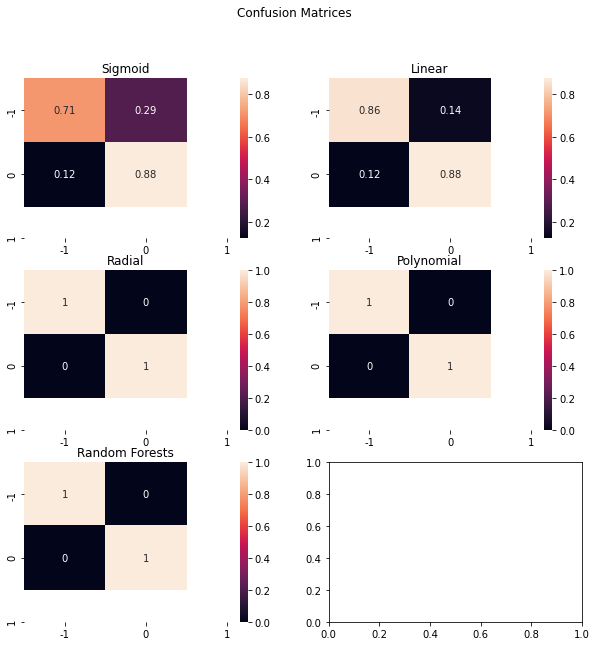

In [7]:
Confusion_Matrix(rbf, lin, poly, sig, rf).show()

## Predicting Playoff Outcomes 

Now we know what teams we are making the playoffs, we want to look at playoff matchups. 
We want to look at the chances teams have of winning given certain playoff matchups. 
We are going to look at their regular season statistics and their head to head matchup results

In [8]:
playoffs = data['playoffs']

## Merge team with stats
MergeMatchupStats = lambda left, right, left_on, right_on: left.merge(
    right, how = 'inner', 
    left_on = [left_on, 'year'], 
    right_on = [right_on, 'year']).drop(columns = ['playoff', right_on])

def FormatPlayoffStats(playoffs, stats): 
    ## Merge playoffs with the stats 
    ## Rename columns to align with the teams 
    
    ## Merge team with stats 
    playoffs = MergeMatchupStats(playoffs, stats, 'winner', 'team')
    playoffs = MergeMatchupStats(playoffs, stats, 'loser', 'team') 
    
    ## Rename columns to accordingly represent the teams
    playoffs.columns = playoffs.columns.str.replace('_x', '_winner') 
    playoffs.columns = playoffs.columns.str.replace('_y', '_loser') 
    
    return playoffs

playoffs = FormatPlayoffStats(playoffs, stats) 
playoffs.head() 

,winner,loser,year,score,fg_winner,fga_winner,3p_winner,3pa_winner,2p_winner,2pa_winner,ft_winner,fta_winner,orb_winner,drb_winner,trb_winner,ast_winner,stl_winner,blk_winner,tov_winner,pf_winner,pts_winner,fg_loser,fga_loser,3p_loser,3pa_loser,2p_loser,2pa_loser,ft_loser,fta_loser,orb_loser,drb_loser,trb_loser,ast_loser,stl_loser,blk_loser,tov_loser,pf_loser,pts_loser
0,toronto_raptors,golden_state_warriors,2019,2,0.7,0.489583,0.471429,0.422886,0.650485,0.627358,0.355263,0.301075,0.210526,0.472527,0.516129,0.569892,0.68750,0.725,0.387755,0.527273,0.746575,1.000000,0.562500,0.600000,0.452736,0.747573,0.627358,0.171053,0.129032,0.236842,0.571429,0.623656,1.000000,0.46875,1.000,0.448980,0.600000,0.972603
1,toronto_raptors,milwaukee_bucks,2019,2,0.7,0.489583,0.471429,0.422886,0.650485,0.627358,0.355263,0.301075,0.210526,0.472527,0.516129,0.569892,0.68750,0.725,0.387755,0.527273,0.746575,0.900000,0.697917,0.628571,0.641791,0.660194,0.514151,0.381579,0.430108,0.131579,1.000000,1.000000,0.634409,0.43750,0.875,0.367347,0.272727,1.000000
2,toronto_raptors,philadelphia_76ers,2019,3,0.7,0.489583,0.471429,0.422886,0.650485,0.627358,0.355263,0.301075,0.210526,0.472527,0.516129,0.569892,0.68750,0.725,0.387755,0.527273,0.746575,0.583333,0.395833,0.242857,0.243781,0.737864,0.754717,0.815789,0.892473,0.552632,0.615385,0.795699,0.731183,0.40625,0.725,0.571429,0.581818,0.801370
3,toronto_raptors,orlando_magic,2019,1,0.7,0.489583,0.471429,0.422886,0.650485,0.627358,0.355263,0.301075,0.210526,0.472527,0.516129,0.569892,0.68750,0.725,0.387755,0.527273,0.746575,0.400000,0.489583,0.328571,0.338308,0.572816,0.707547,0.000000,0.000000,0.315789,0.450549,0.537634,0.580645,0.15625,0.750,0.224490,0.090909,0.260274
4,golden_state_warriors,portland_trail_blazers,2019,0,1.0,0.562500,0.600000,0.452736,0.747573,0.627358,0.171053,0.129032,0.236842,0.571429,0.623656,1.000000,0.46875,1.000,0.448980,0.600000,0.972603,0.716667,0.645833,0.271429,0.268657,0.796117,0.839623,0.526316,0.440860,0.789474,0.538462,0.817204,0.311828,0.18750,0.650,0.346939,0.418182,0.767123


In [9]:
## Split into x and y 
def SplitPlayoffs(playoffs): 
    ## Split data into x and y 
    
    playoffs = playoffs.sort_values(by = 'year', axis = 0)
    playoffs_x = playoffs[playoffs.columns[4:]]
    playoffs_y = playoffs.score 
    
    return playoffs_x, playoffs_y 

playoffs_x, playoffs_y = SplitPlayoffs(playoffs) 

In [10]:
rbf_playoffs, lin_playoffs, poly_playoffs, sig_playoffs, rf_playoffs = AllModels(x, y) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
The radial Model Score is: 1.0
Fitting 5 folds for each of 5 candidates, totalling 25 fits
The linear Model Score is: 0.8666666666666667
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The poly Model Score is: 1.0
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The sigmoid Model Score is: 0.8
Fitting 5 folds for each of 100 candidates, totalling 500 fits
The Random Forest Model Score is: 1.0


<ipython-input-11-5f9e2cfe70db>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Confusion_Matrix(rbf_playoffs,


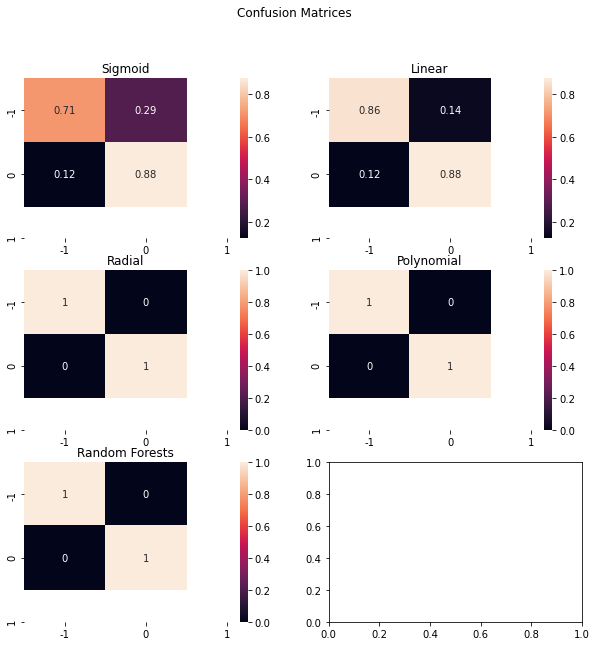

In [11]:
Confusion_Matrix(rbf_playoffs, 
                 lin_playoffs, 
                 poly_playoffs,
                 sig_playoffs, 
                 rf_playoffs).show()